In [5]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle

sys.path.append(os.path.abspath("../analysis_tools/"))
from utils import * 

# pycytominer imports
from pycytominer import aggregate, annotate, normalize, feature_select
from pycytominer import feature_select

# load first few rows from parquet
import fastparquet

# for median absolute deviation
import scipy.stats as ss

# for Louvain clustering
import community as community_louvain
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
import scipy.spatial as spt

# make cell crops
import skimage.io

# for legends heatmap annotations
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

# upset plots
from upsetplot import generate_counts, plot
from upsetplot import UpSet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Import other datasets
# Anderson data
anderson_data = \
    pd.read_csv('../LMNA_PBv2b_T3_pycytominer_pipelinev2_121624/anderson_2021_variantdata_Formatted.csv')

# Clinvar
clinvar_variants_filterconditions = \
    pd.read_csv('../LMNA_PBv2b_T3_pycytominer_pipelinev2_121624/clinvar_LMNA_missense_ex345_061824_fixed.csv')
condition_map = {'DCM':'DCM', 'Myopathy':'EDMD', 'Lipodystrophy':'FPLD', 'Progeria':'HGPS'}
for disease in ['DCM','Myopathy','Lipodystrophy','Progeria']:
    clinvar_variants_filterconditions[disease] = \
        clinvar_variants_filterconditions["Mapped Conditions"]\
            .map(lambda x: True if condition_map[disease] in x else False)

# Define one way to color variants, use when highlighting specific variants
variant_type_palette = \
    {'Single Missense':'grey',
     'Synonymous':'darkgreen',
     'WT':'grey', 
     'Frameshift':'purple', 
     '3nt Deletion':'grey', 
     'Nonsense':'purple', 
     'Other':'grey'}

# Variants filtered for spliceAI scores
lmna_variants_spliceAIfiltered = \
    pd.read_csv('./LMNA_AM_CV.csv')



In [7]:
# Import Gwen's ROC AUC
roc_auc_lmna = pd.read_csv('../Gwen_ROC/LMNA/results/train_results.csv')
roc_auc_lmna = roc_auc_lmna[['aaChanges','test_roc_auc','Example Count']].rename(columns={'aaChanges':'Variant','test_roc_auc':'AUC ROC'})
roc_auc_lmna['Morphological Distinguishability'] = roc_auc_lmna['AUC ROC'].map(lambda x: max(2*x-1,0))
roc_auc_lmna_controls = \
    pd.read_csv("../Gwen_ROC/LMNA/results-control/train_results.csv")
roc_auc_lmna_controls = roc_auc_lmna_controls[['aaChanges','test_roc_auc']].rename(columns={'aaChanges':'Variant','test_roc_auc':'AUC ROC'})
roc_auc_lmna_replicates = \
    pd.read_csv("../Gwen_ROC/LMNA/results-replicate/train_results.csv").drop(columns='Unnamed: 0').rename(columns={'aaChanges':'Variant','test_roc_auc':'AUC ROC'})


In [4]:
# LMNA information
start_pos = 178
end_pos = 273
LMNA_domain_map = {}
for pos in range(start_pos, end_pos+1):
    if pos < 222:
        LMNA_domain_map[pos] = "Coil 1B"
    elif pos <= 241:
        LMNA_domain_map[pos] = "Linker 12"
    else:
        LMNA_domain_map[pos] = "Coil 2A"
LMNA_domain_colors = \
    {
        'Coil 1B':'goldenrod',
        'Linker 12':'lime',
        'Coil 2A':'deepskyblue'
    }

# Set up for making feature plots
LMNA_WT_nuc_seq = \
    'ATGGAGACCCCGTCCCAGCGGCGCGCCACCCGCAGCGGGGCGCAGGCCAGCTCCACTCCGCTGTCGCCCACCCGCATCACCCGGCTGCAGGAGAAGGAGGACCTGCAGGAGCTCAATGATCGCTTGGCGGTCTACATCGACCGTGTGCGCTCGCTGGAAACGGAGAACGCAGGGCTGCGCCTTCGCATCACCGAGTCTGAAGAGGTGGTCAGCCGCGAGGTGTCCGGCATCAAGGCCGCCTACGAGGCCGAGCTCGGGGATGCCCGCAAGACCCTTGACTCAGTAGCCAAGGAGCGCGCCCGCCTGCAGCTGGAGCTGAGCAAAGTGCGTGAGGAGTTTAAGGAGCTGAAAGCGCGCAATACCAAGAAGGAGGGTGACCTGATAGCTGCTCAGGCTCGGCTGAAGGACCTGGAGGCTCTGCTGAACTCCAAGGAGGCCGCACTGAGCACTGCTCTCAGTGAGAAGCGCACGCTGGAGGGCGAGCTGCATGATCTGCGGGGCCAGGTGGCCAAGCTTGAGGCAGCCCTAGGTGAGGCCAAGAAACAGCTGCAGGACGAAATGCTGCGGCGGGTGGATGCTGAGAACAGGCTGCAGACCATGAAGGAGGAACTGGACTTCCAGAAGAACATCTACAGTGAGGAGCTGCGTGAGACCAAGCGCCGTCATGAGACCCGACTGGTGGAGATTGACAATGGGAAGCAGCGTGAGTTTGAGAGCCGGCTGGCGGATGCGCTGCAGGAACTGCGGGCCCAGCATGAGGACCAGGTGGAGCAGTATAAGAAGGAGCTGGAGAAGACTTATTCTGCCAAGCTGGACAATGCCAGGCAGTCTGCTGAGAGGAACAGCAACCTGGTGGGGGCTGCCCACGAGGAGCTGCAGCAGTCGCGCATCCGCATCGACAGCCTCTCTGCCCAGCTCAGCCAGCTCCAGAAGCAGCTGGCAGCCAAGGAGGCGAAGCTTCGAGACCTGGAGGACTCACTGGCCCGTGAGCGGGACACCAGCCGGCGGCTGCTGGCGGAAAAGGAGCGGGAGATGGCCGAGATGCGGGCAAGGATGCAGCAGCAGCTGGACGAGTACCAGGAGCTTCTGGACATCAAGCTGGCCCTGGACATGGAGATCCACGCCTACCGCAAGCTCTTGGAGGGCGAGGAGGAGAGGCTACGCCTGTCCCCCAGCCCTACCTCGCAGCGCAGCCGTGGCCGTGCTTCCTCTCACTCATCCCAGACACAGGGTGGGGGCAGCGTCACCAAAAAGCGCAAACTGGAGTCCACTGAGAGCCGCAGCAGCTTCTCACAGCACGCACGCACTAGCGGGCGCGTGGCCGTGGAGGAGGTGGATGAGGAGGGCAAGTTTGTCCGGCTGCGCAACAAGTCCAATGAGGACCAGTCCATGGGCAATTGGCAGAtCAAGCGCCAGAATGGAGACGACCCACTGCTCACCTACCGGTTCCCACCAAAGTTCACCCTGAAGGCTGGGCAGGTGGTGACGATCTGGGCTGCAGGAGCTGGGGCCACCCACAGCCCCCCTACCGACCTGGTGTGGAAGGCACAGAACACCTGGGGCTGCGGGAACAGCCTGCGTACGGCTCtCATCAACTCCACTGGGGAAGAAGTGGCCATGCGCAAGCTGGTGCGCTCAGTGACTGTGGTTGAGGACGACGAGGATGAGGATGGAGATGACCTGCTCCATCACCACCACGGCTCCCACTGCAGCAGCTCGGGGGACCCCGCTGAGTACAACCTGCGCTCGCGCACCGTGCTGTGCGGGACCTGCGGGCAGCCTGCCGACAAGGCATCTGCCAGCGGCTCAGGAGCCCAGGTGGGCGGACCCATCTCCTCTGGCTCTTCTGCCTCCAGTGTCACGGTCACTCGCAGCTACCGCAGTGTGGGGGGCAGTGGGGGTGGCAGCTTCGGGGACAATCTGGTCACCCGCTCCTACCTCCTGGGCAACTCCAGCCCCCGAACCCAGAGCCCCCAGAACTGCAGCATCATGTAG'
LMNA_WT_aa_seq = \
    str(Seq(LMNA_WT_nuc_seq).translate())
lmna_pymol_view = \
    '''set_view (\
        -0.915147185,    0.403044611,   -0.007183676,\
        -0.175614133,   -0.414666086,   -0.892865419,\
        -0.362844229,   -0.815845907,    0.450264663,\
         0.000000000,    0.000000000, -382.015167236,\
      -190.245574951, -108.335136414,  109.851905823,\
       301.183654785,  462.846679688,  -20.000000000 )'''
lmna_pymol_view2 = \
    '''set_view (\
     0.071904697,   -0.778118074,   -0.623987436,\
     0.870689154,    0.354146332,   -0.341291487,\
     0.486548126,   -0.518758714,    0.702964723,\
     0.000000000,    0.000000000, -374.783477783,\
    -2.406383991,  -20.413566589,  -11.670532227,\
   295.482147217,  454.084808350,  -20.000000000 )'''



In [8]:
# Read profiles
df_profiles_merged = pd.read_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_010425.csv', index_col=None)
df_profiles_merged.drop(columns='Unnamed: 0',inplace=True)
df_profiles_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_merged['Variant_Class'], 
                   categories=['Synonymous','Single Missense','Frameshift'], 
                   ordered=True)
features_common = [c for c in df_profiles_merged.columns if c not in ['Variant','Variant_Class',
                                                                      'NCells_R1','NCells_R2',
                                                                      'UMAP1','UMAP2',
                                                                      'Louvain Cluster']]

# Read p-values
df_KSpvalues_merged = \
    pd.read_csv('./consensus_profiles/LMNA_merged_KSpvalues_010924.csv')
df_KSpvalues_merged.index = df_KSpvalues_merged['Variant']
df_KSpvalues_merged.drop(columns='Variant',inplace=True)

# Read features
variant_medians_merged = \
    pd.read_csv('./consensus_profiles/LMNA_merged_featuremedians_010625.csv')
variant_medians_merged.drop(columns='Unnamed: 0', inplace=True)
variant_medians_merged['Variant_Class'] = \
    pd.Categorical(variant_medians_merged['Variant_Class'], 
                   categories=['Synonymous','Single Missense','Frameshift'],
                   ordered=True)
variant_EMD_merged = \
    pd.read_csv('./consensus_profiles/LMNA_merged_featureEMD_010925.csv')
variant_EMD_merged.drop(columns='Unnamed: 0', inplace=True)
variant_EMD_merged['Variant_Class'] = \
    pd.Categorical(variant_EMD_merged['Variant_Class'], 
                   categories=['Synonymous','Single Missense','Frameshift'],
                   ordered=True)

# Get umap coordinates
umap_coords = \
    df_profiles_merged[['Variant','UMAP1','UMAP2']]

# Highlight biochemical controls
punctuate_controls = ['N195K','L248P','E203G','R189P']
non_punctuate_controls = ['D192V', 'R189W', 'E203K', 'E203V', 'E262K', 'E202K', 'R190Q']
total_controls = punctuate_controls + non_punctuate_controls
umap_coords['Highlight'] = \
    umap_coords['Variant'].map(lambda x: True if x in total_controls else False)
umap_coords['HighlightClass'] = \
    umap_coords['Variant'].map(lambda x: 'Punctuate' if x in punctuate_controls \
                                                     else 'Non-Punctuate' if x in non_punctuate_controls \
                                                     else 'WT' if x == 'WT' \
                                                     else np.nan)



In [9]:
len(features_common)

333

In [170]:
# Pull single cell feature information to find cells
# Write function to look up cell crops and show them
# visualize cells
# Phenotyping paths
features_to_pull = \
    [
     'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1',
     'Mean_Nuclei_AreaShape_FormFactor',
     'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1',
     'Mean_NucleiExpanded_Granularity_1_CH1',
     'Mean_Nuclei_AreaShape_Eccentricity',
     'Mean_Nuclei_AreaShape_Solidity',
    ]

r1_phenotyping_path = '/net/fowler/vol1/shared/fisseq/PBv2b_T3R1/phenotyping/'
r2_phenotyping_path = '/net/fowler/vol1/shared/fisseq/PBv2b_T3R2/phenotyping/'

# Import cell information
genotypes_df_r1 = \
    pd.read_parquet('./R1_features/LMNAT3R1.cellprofiler_122824.cells_full.parquet', 
                    columns=['upBarcode',
                             'aaChanges',
                             'editDistance',
                             'AreaShape_Center_X',
                             'AreaShape_Center_Y',
                             'tile_x',
                             'tile_y',
                             'tile_index',
                             'well']+\
                            features_to_pull
                   )
genotypes_df_r1 = \
    genotypes_df_r1\
       .assign(Replicate=1)\
       .query('editDistance in [0,1]')
genotypes_df_r1['PhenotypePath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y']), 
                          axis=1)
genotypes_df_r1['DAPIPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel0.tif'), 
                          axis=1)
genotypes_df_r1['CellMaskPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='cells.tif'), 
                          axis=1)

genotypes_df_r2 = \
    pd.read_parquet('./R2_features/LMNAT3R2.cellprofiler_122824.cells_full.parquet', 
                    columns=['upBarcode',
                             'aaChanges',
                             'editDistance',
                             'AreaShape_Center_X',
                             'AreaShape_Center_Y',
                             'tile_x',
                             'tile_y',
                             'tile_index',
                             'well']+\
                            features_to_pull
                   )
genotypes_df_r2 = \
    genotypes_df_r2\
       .assign(Replicate=2)\
       .query('editDistance in [0,1]')
genotypes_df_r2['PhenotypePath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel1.tif'), 
                          axis=1)
genotypes_df_r2['DAPIPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel0.tif'), 
                          axis=1)
genotypes_df_r2['CellMaskPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='cells.tif'), 
                          axis=1)

# merge
genotypes_df = pd.concat([genotypes_df_r1,genotypes_df_r2], axis=0)


In [10]:
# Plot UMAP with Anderson controls
# ------------------------------------
# Data setup
# ------------------------------------
variants_assayed_umap_toplot = df_profiles_merged.copy()
variants_assayed_umap_toplot = pd.merge(
    variants_assayed_umap_toplot.reset_index(drop=True),
    anderson_data,
    on='Variant',
    how='left'
)

variantssorted_bypunctuate = (
    anderson_data[['Variant','HEK']]
    .drop_duplicates()
    .sort_values(by='HEK')['Variant']
    .values
)
variantssorted_bypunctuate = variantssorted_bypunctuate[variantssorted_bypunctuate != 'WT']
variants_assayed_umap_toplot = variants_assayed_umap_toplot.sort_values(by='Variant')
variant_anno = (
    variants_assayed_umap_toplot
    .query('Variant_Class == "Single Missense"')
    .query('~`HEK`.isna()')
)

# ------------------------------------
# Plotting
# ------------------------------------
fig = plt.figure(figsize=(5,4.7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

# --- Plotting the data ---
# Background (greyed out) points:
sns.scatterplot(
    data=variants_assayed_umap_toplot,
    x='UMAP1',
    y='UMAP2',
    color='grey',
    alpha=0.3,
    s=40,
    ax=ax,
    legend=False
)

# Highlighted (Anderson) points:
sns.scatterplot(
    data=variant_anno.rename(
        columns={'HEK': 'Anderson et al. (2021)\nPercent Punctate'}
    ),
    x='UMAP1',
    y='UMAP2',
    hue='Anderson et al. (2021)\nPercent Punctate',
    palette="viridis",
    s=300,
    marker='^',
    ax=ax,
    legend=False
)

# Set up the ScalarMappable for the colorbar:
norm = mcolors.Normalize(vmin=0, vmax=50)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Create the colorbar in the reserved axis:
cbar = plt.colorbar(sm, cax=cax, extend="both", spacing="proportional",
                     boundaries=np.linspace(0, 50))
cbar.ax.set_yscale('linear')
cbar.set_ticklabels(ticklabels=[0,10,20,30,40,50],fontsize=14)

# Final formatting of the main axes:
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1', fontsize=16)
ax.set_ylabel('UMAP 2', fontsize=16)
plt.tight_layout()
plt.close()

# ------------------------------------
# (Optional) Save the figure
# ------------------------------------
fig.savefig('./consensus_plots/LMNAT3.UMAP.andersonvariants.011025.pdf', dpi=600)


In [11]:
# Plot against clinvar designation
clinvar_variants_filtersplice = \
    clinvar_variants_filterconditions\
        .rename(columns={'aaChanges':'Variant'})\
        .query('Variant in @lmna_variants_spliceAIfiltered["protein_variant"]')
variants_assayed_umap_toplot = \
    df_profiles_merged
variants_assayed_umap_toplot = pd.merge(variants_assayed_umap_toplot, 
                                        clinvar_variants_filtersplice\
                                            [['Variant','Variant Designation','Mapped Conditions']],
                                        on='Variant', 
                                        how='left')
variant_anno = \
    variants_assayed_umap_toplot\
        .query('Variant_Class == "Single Missense"')\
        .query('~`Variant Designation`.isna()')
    
fig,ax=plt.subplots(figsize=(4,4))
sns.scatterplot(data=variants_assayed_umap_toplot, 
                x='UMAP1',
                y='UMAP2', 
                #hue='Variant_Class', 
                color='grey',
                alpha=0.3,
                #palette=variant_type_palette,
                s=40,
                ax=ax,
                legend=False)
variant_anno['zorder'] = \
    variant_anno['Variant Designation'].map({'VUS':0,'B/LB':1,'P/LP':2})
variant_anno = variant_anno.sort_values(by='zorder')
sns.scatterplot(data=variant_anno\
                    .rename(columns={'Variant Designation':'ClinVar'}),
                x='UMAP1',
                y='UMAP2', 
                hue='ClinVar', 
                palette={'VUS':'yellow',
                         'B/LB':'blue',
                         'P/LP':'red'},
                s=300,
                marker="^",
                ax=ax
               )

# Remove x-axis tick labels and ticks
plt.xticks([])

# Remove y-axis tick labels and ticks
plt.yticks([])

# Set legend info
plt.legend(fontsize=14, title='', title_fontsize=16)

# Label x and y-axes
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)

plt.tight_layout()
plt.close()

fig.savefig('./consensus_plots/LMNAT3.UMAP.clinvarvariants.011025.pdf', dpi=600)


In [12]:
# Plot grey Single Missense points first (in the back) with lower alpha,
# synonymous and frameshift points larger, and P/LP variants on top

# Split the data into grey points and other points
subset_grey = df_profiles_merged[df_profiles_merged['Variant_Class'] == 'Single Missense']
subset_color = df_profiles_merged[df_profiles_merged['Variant_Class'] != 'Single Missense']
variant_anno = pd.merge(subset_grey, 
                        clinvar_variants_filtersplice\
                            [['Variant','Variant Designation','Mapped Conditions']]\
                            .query('`Variant Designation`.isin(["P","LP","P/LP"])'),
                        on='Variant', 
                        how='inner')


# Create the figure and axis
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(data=subset_grey, 
                x='UMAP1', 
                y='UMAP2', 
                color='grey', 
                s=40, 
                alpha=0.3,
                ax=ax,
                legend=False)

# Plot the colored points on top
sns.scatterplot(data=subset_color, 
                x='UMAP1', 
                y='UMAP2', 
                hue='Variant_Class',
                palette={'Synonymous': 'green',
                         'Single Missense': 'grey',
                         'Frameshift': 'purple'},
                s=40,
                ax=ax,
                legend=False)

# Plot path variants
sns.scatterplot(data=variant_anno\
                    .rename(columns={'Variant Designation':'ClinVAR'}),
                x='UMAP1',
                y='UMAP2', 
                hue='ClinVAR', 
                palette={'P/LP':'red'},
                s=150,
                marker="^",
                ax=ax
               )

# Create custom legend entries
syn = mlines.Line2D([], [], color='green', marker='o', linestyle='',
                    markersize=7, label='Synonymous')
sm = mlines.Line2D([], [], color='grey', marker='o', linestyle='',
                    markersize=7, alpha=0.3, label='Single\nMissense')
fs = mlines.Line2D([], [], color='purple', marker='o', linestyle='',
                   markersize=7, label='Frameshift')

# Add the custom legend
# first legend: variant types
legend1 = ax.legend(handles=[syn, sm, fs],
                    markerscale=1,
                    title='Variant Type',
                    loc='upper right',
                    fontsize=10,
                    title_fontsize=11)
ax.add_artist(legend1)

# **second handle for ClinVar P/LP**
clinvar = mlines.Line2D([], [], color='red', marker='^', linestyle='',
                        markersize=8, label='ClinVar P/LP')

# **second legend: ClinVar**
ax.legend(handles=[clinvar],
          loc='lower right',
          fontsize=10,
          title_fontsize=12)

# Remove x-axis and y-axis tick labels and ticks
plt.xticks([])
plt.yticks([])

# Label axes
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.tight_layout()

# Save the figure
fig.savefig('./consensus_plots/LMNAT3.UMAP.clinvarpath.053025.pdf', dpi=600)
plt.close()


In [13]:
# Compute morphological distance
# Define phenotyping impact scores
df_profiles_synmedian = \
    df_profiles_merged\
        .query('Variant_Class == "Synonymous"')\
        [features_common].agg(np.median)

# compute cosine similarity to median synonymous profile
variant_cosine_similarity = \
    cosine_similarity(df_profiles_merged[features_common], df_profiles_synmedian.values.reshape(1,-1))
df_profiles_merged['Morphological Impact Score'] = \
    (1-variant_cosine_similarity[:,0])/2


In [14]:
# Plot impact as a function of variant class, including anderson controls and clinVAR data
# merge with anderson controls data
df_toplot = df_profiles_merged.copy()
df_toplot = pd.merge(
    df_toplot.reset_index(drop=True),
    anderson_data,
    on='Variant',
    how='left'
)
punctate_label='Aggreg.\nControls'

# merge with clinVAR
# Remove single clinvar benign
clinvar_variants_filtersplice = \
    clinvar_variants_filterconditions\
        .rename(columns={'aaChanges':'Variant'})\
        .query('Variant in @lmna_variants_spliceAIfiltered["protein_variant"]')
clinvar_variants_filtersplice_benignremoved = \
    clinvar_variants_filtersplice\
        .query('`Variant Designation` != "B/LB"')
df_toplot2 = pd.merge(df_toplot, 
                      clinvar_variants_filtersplice_benignremoved\
                         [['Variant','Variant Designation','Mapped Conditions']],
                      on='Variant', 
                      how='left')
df_toplot2 = \
    df_toplot2.rename(columns={'Variant Designation':'ClinVAR Label'})
df_toplot3 = df_toplot2.copy()

# Core variant‐class categories
df_toplot3['Synonymous']        = df_toplot3['Variant_Class'] == 'Synonymous'
df_toplot3['Single Missense']   = df_toplot3['Variant_Class'] == 'Single Missense'
df_toplot3['Frameshift']        = df_toplot3['Variant_Class'] == 'Frameshift'

# Punctate control
df_toplot3[punctate_label]          = df_toplot3['HEK'] >= 15

# ClinVAR categories from your merged clinvar table
df_toplot3['ClinVAR VUS']  = df_toplot3['ClinVAR Label'] == 'VUS'
df_toplot3['ClinVAR P/LP'] = df_toplot3['ClinVAR Label'].isin(['P','LP','P/LP'])

# Melt
id_vars    = ['Variant','Morphological Impact Score']
value_vars = [
    'Synonymous','Single Missense','Frameshift',
    punctate_label,'ClinVAR VUS','ClinVAR P/LP'
]

df_long = df_toplot3.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='Category',
    value_name='InCategory'
)

# keep only the True rows
df_long = df_long[df_long['InCategory']]

# Plot figure
fig, ax = plt.subplots(figsize=(5,4))
boxplot_with_significance(
    df=df_long,
    x_col='Category',
    y_col='Morphological Impact Score',
    hue_col='Category',  # same as x_col
    order=['Synonymous','Single Missense','Frameshift',punctate_label,'ClinVAR VUS','ClinVAR P/LP'],
    palette={'Synonymous':'darkgreen',
             'Single Missense':'grey',
             'Frameshift':'purple',
             punctate_label:'#43C59E',
             'ClinVAR VUS':'yellow',
             'ClinVAR P/LP':'red'
            },
    alpha=0.001,    # Show significance if p < 0.001
    pairs=[("Synonymous",'Single Missense'),
           ('Single Missense',"Frameshift"),
           ("Synonymous",punctate_label),
           ('Single Missense',punctate_label),
           ("Synonymous","ClinVAR P/LP"),
           ("ClinVAR VUS","ClinVAR P/LP")],
    offset=0.02,
    xlabels=["Syn","Single\nMissense","Frame-\nshift",punctate_label,"VUS","P/LP"],
    xlabel_fontsize=10.5,
    ax=ax
)

plt.ylim(0, 1)
plt.ylabel('Morphological Impact Score', fontsize=16)
plt.xlabel('')
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.close()
fig.savefig('./consensus_plots/morphological_impact.variantclass_punctate_clinVAR.053025.pdf', dpi=600)


In [15]:
# Plot impact as a function of variant class, including anderson controls
# merge with anderson controls data
df_toplot = df_profiles_merged.merge(roc_auc_lmna, on='Variant', how='inner').copy()
df_toplot = pd.merge(
    df_toplot.reset_index(drop=True),
    anderson_data,
    on='Variant',
    how='left'
)
punctate_label='Aggreg.\nControls'

# merge with clinVAR
# Remove single clinvar benign
clinvar_variants_filtersplice = \
    clinvar_variants_filterconditions\
        .rename(columns={'aaChanges':'Variant'})\
        .query('Variant in @lmna_variants_spliceAIfiltered["protein_variant"]')
clinvar_variants_filtersplice_benignremoved = \
    clinvar_variants_filtersplice\
        .query('`Variant Designation` != "B/LB"')
df_toplot2 = pd.merge(df_toplot, 
                      clinvar_variants_filtersplice_benignremoved\
                         [['Variant','Variant Designation','Mapped Conditions']],
                      on='Variant', 
                      how='left')
df_toplot2 = \
    df_toplot2.rename(columns={'Variant Designation':'ClinVAR Label'})
df_toplot3 = df_toplot2.copy()

# Core variant‐class categories
df_toplot3['Synonymous']        = df_toplot3['Variant_Class'] == 'Synonymous'
df_toplot3['Single Missense']   = df_toplot3['Variant_Class'] == 'Single Missense'
df_toplot3['Frameshift']        = df_toplot3['Variant_Class'] == 'Frameshift'

# Punctate control
df_toplot3[punctate_label]          = df_toplot3['HEK'] >= 15

# ClinVAR categories from your merged clinvar table
df_toplot3['ClinVAR VUS']  = df_toplot3['ClinVAR Label'] == 'VUS'
df_toplot3['ClinVAR P/LP'] = df_toplot3['ClinVAR Label'].isin(['P','LP','P/LP'])

# Melt
id_vars    = ['Variant','AUC ROC']
value_vars = [
    'Synonymous','Single Missense','Frameshift',
    punctate_label,'ClinVAR VUS','ClinVAR P/LP'
]

df_long = df_toplot3.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='Category',
    value_name='InCategory'
)

# keep only the True rows
df_long = df_long[df_long['InCategory']]

# add on controls
wt_controls_name = 'WT Samples'
roc_auc_lmna_controls['Category'] = wt_controls_name
df_long_pluscontrols = \
    pd.concat([df_long[['Variant','AUC ROC','Category']], roc_auc_lmna_controls])

# Plot figure
color_palette_toplot = \
    {
        wt_controls_name:'palegreen',
        'Synonymous':'darkgreen',
        'Single Missense':'grey',
        'Frameshift':'purple',
        punctate_label:'#43C59E',
        'ClinVAR VUS':'yellow',
        'ClinVAR P/LP':'red'
    }
fig, ax = plt.subplots(figsize=(5.5,4))
boxplot_with_significance(
    df=df_long_pluscontrols,
    x_col='Category',
    y_col='AUC ROC',
    hue_col='Category',  # same as x_col
    order=list(color_palette_toplot.keys()),
    palette=color_palette_toplot,
    alpha=0.001,    # Show significance if p < 0.001
    pairs=[("Synonymous",'Single Missense'),
           ('Single Missense',"Frameshift"),
           ("Synonymous",punctate_label),
           ('Single Missense',punctate_label),
           ("Synonymous","ClinVAR P/LP"),
           ("ClinVAR VUS","ClinVAR P/LP")],
    xlabels=["WT\nSamples",
             "Syn","Single\nMissense","Frame-\nshift",
             punctate_label,"VUS","P/LP"],
    xlabel_fontsize=10.5,
    offset=0.0125,
    ax=ax
)

plt.ylim(0.45, 1)
plt.ylabel('AUROC', fontsize=16)
plt.xlabel('')
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.close()
fig.savefig('./consensus_plots/aucroc.variantclass_punctate_clinVAR.053025.pdf', dpi=600)


In [16]:
# Plot ROC AUC vs morphological impact
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(data=df_toplot,
                y="AUC ROC", 
                x="Morphological Impact Score", 
                hue="Variant_Class",
                palette=variant_type_palette,
                ax=ax
               )

# Add labels
ax.set_xlabel('Morphological Impact Score', fontsize=14)
ax.set_ylabel('AUROC', fontsize=14)
ax.tick_params(labelsize=12)

# Compute linear regression
x = df_toplot["Morphological Impact Score"]
y = df_toplot["AUC ROC"]
slope, intercept, r_value, p_value, std_err = linregress(x,y)
# Prepare line values for the best-fit line
line_x = np.linspace(x.min(), x.max(), 100)
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, color='red')

# Display R^2 on the plot
ax.text(
    0.7, 0.9, 
    f'$R = {r_value:.2f}$', 
    transform=ax.transAxes, 
    fontsize=20, 
    bbox=dict(facecolor='white', alpha=0.5)
)
plt.tight_layout()

# Show legend and plot
ax.legend(loc='upper left', markerscale=2, fontsize=12, title_fontsize=14, title='Variant Type')
fig.savefig('./consensus_plots/LMNAT3.aucrocVSmorphologicalimpactscore.061025.pdf')
plt.close()


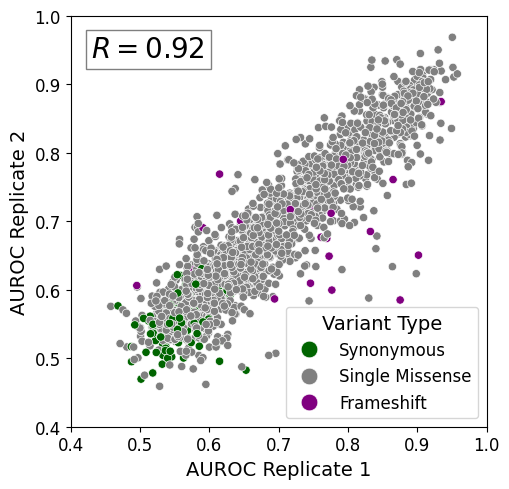

In [50]:
# Plot ROC AUC as a function of number of training examples
df_toplot = \
    df_profiles_merged\
        .merge(roc_auc_lmna_replicates.query('replicate==1')[['AUC ROC','Variant']].rename(columns={'AUC ROC':'AUC ROC Replicate 1'}), 
               on='Variant', how='inner')\
        .merge(roc_auc_lmna_replicates.query('replicate==2')[['AUC ROC','Variant']].rename(columns={'AUC ROC':'AUC ROC Replicate 2'}), 
               on='Variant', how='inner')

# Compute linear regression parameters
r1_auc = df_toplot['AUC ROC Replicate 1']
r2_auc = df_toplot['AUC ROC Replicate 2']

slope, intercept, r_value, p_value, std_err = ss.linregress(r1_auc, r2_auc)

# Prepare line values for the best-fit line
line_x = np.linspace(r1_auc.min(), r2_auc.max(), 100)
line_y = slope * line_x + intercept

# Plot
fig, ax = plt.subplots(figsize=(5.2, 5))
sns.scatterplot(x=r1_auc, 
                y=r2_auc, 
                hue=df_toplot['Variant_Class'],
                palette=variant_type_palette,
                ax=ax,
                )
#ax.plot(line_x, line_y, color='red', label='Best Fit Line')

# Add labels
ax.set_xlabel('AUROC Replicate 1', fontsize=14)
ax.set_ylabel('AUROC Replicate 2', fontsize=14)
ax.set_xlim(0.4,1)
ax.set_ylim(0.4,1)

# Display R^2 on the plot
ax.text(
    0.05, 0.9, 
    f'$R = {r_value:.2f}$', 
    transform=ax.transAxes, 
    fontsize=20, 
    bbox=dict(facecolor='white', alpha=0.5)
)

# Show legend and plot
ax.legend(loc='lower right', markerscale=2, title='Variant Type', title_fontsize=14, fontsize=12)
ax.tick_params(labelsize=12)
plt.tight_layout()
fig.savefig('./consensus_plots/LMNAT3.AUROC.correlationbetweenreps.061325.pdf')
plt.show()


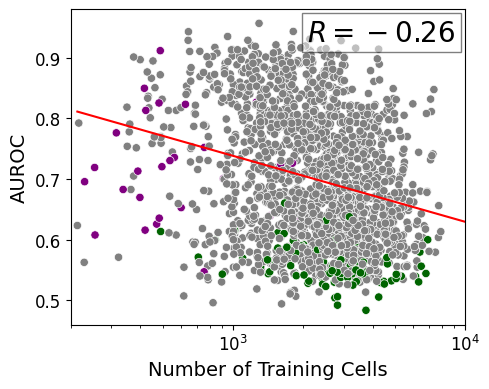

In [153]:
# Plot ROC AUC as a function of number of training examples
graph_auc_examples(
    df_profiles_merged.merge(roc_auc_lmna, on='Variant', how='inner'),
    img_save_path = "./consensus_plots/LMNAT3.auc_roc.trainingexamples.061125.pdf",
    log_axis = True,
    xlim = (200,10000),
)

In [65]:
# Relabel clusters
cluster_remap = \
    {
        0: 8,
        1: 9,
        2: 2,
        3: 10,
        4: 3,
        5: 4,
        6: 6,
        7: 7,
        8: 5,
        9: 1
    }
df_profiles_merged['Cluster'] = \
    df_profiles_merged['Louvain Cluster'].map(lambda x: cluster_remap[x])


In [10]:
# Visualize Louvain Clusters
# Look at UMAP clusters
fig,ax=plt.subplots(figsize=(4,4))
sns.scatterplot(data=df_profiles_merged, 
                x='UMAP1', 
                y='UMAP2', 
                hue='Cluster', 
                s=25, 
                palette=sns.color_palette(),
                legend=False)

# plt.legend(markerscale=3, 
#            #bbox_to_anchor=(1.02,1), 
#            fontsize=14,
#            title_fontsize=16,
#            loc='lower left',
#            mode="expand",
#            )

# Remove x-axis tick labels and ticks
plt.xticks([])

# Remove y-axis tick labels and ticks
plt.yticks([])

# Set labels
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)

plt.tight_layout()
plt.close()
fig.savefig('./consensus_plots/LMNAT3.UMAP.LouvainCluster.v2.021325.pdf', dpi=600)


In [21]:
# Save relabeled clusters
df_profiles_merged.to_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_clusterlabeled_021325.csv')


In [17]:
# Import df profiles merged with cluster relabeled
df_profiles_merged = pd.read_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_clusterlabeled_021325.csv')
df_profiles_merged.drop(columns='Unnamed: 0', inplace=True)


In [18]:
# Combine all features
df_features_tot = \
    df_profiles_merged[['Variant',
                        'NCells_R1','NCells_R2',
                        'Variant_Class',
                        'UMAP1','UMAP2',
                        'Cluster',
                        'Morphological Impact Score']]\
        .merge(variant_medians_merged\
                   .drop(columns='Variant_Class')\
                   .rename(columns={c:c+'_median' for c in variant_medians_merged.columns if "Variant" not in c}),
               on='Variant'
              )\
        .merge(variant_EMD_merged\
                   .drop(columns='Variant_Class')\
                   .rename(columns={c:c+'_EMD' for c in variant_medians_merged.columns if "Variant" not in c}),
               on='Variant')


In [19]:
# Heatmap of landmark features over clusters
nclust=np.max(df_profiles_merged['Cluster'].values)
landmark_features = \
    ['Mean_NucleiExpanded_Intensity_MeanIntensity_CH1',
     'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1',
     'Mean_NucleiExpanded_Granularity_1_CH1',
     'Mean_Nuclei_AreaShape_FormFactor',
    ]
feature_rename = \
    {
     'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1':'LMNA Nuclear\nIntensity',
     'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1':'LMNA Nuclear\nBoundary Intensity',
     'Mean_NucleiExpanded_Granularity_1_CH1':'LMNA Nuclear\nGranularity 1',
     'Mean_Nuclei_AreaShape_FormFactor': 'Nuclear Shape\nFactor',
    }
variant_class_palette = \
    {(i+1):sns.color_palette('tab10')[i] for i in range(nclust)}
variant_medianEMD_landmark_merged_withcluster = \
    variant_medians_merged[['Variant']+landmark_features]\
        .rename(columns={x:feature_rename[x]+' median' for x in landmark_features})\
        .merge(variant_EMD_merged[['Variant']+landmark_features]\
                   .rename(columns={x:feature_rename[x]+' EMD' for x in landmark_features}), 
               on='Variant')\
        .merge(df_profiles_merged[['Variant','Cluster']], on='Variant')
total_landmark_features = \
    [feature_rename[c]+' median' for c in landmark_features] + \
    [feature_rename[c]+' EMD' for c in landmark_features]
medianvalues_landmark_features_bycluster = \
    variant_medianEMD_landmark_merged_withcluster\
        [total_landmark_features+['Cluster']]\
        .groupby('Cluster')\
        .agg(np.median)

landmark_clustermap = \
    sns.clustermap(medianvalues_landmark_features_bycluster.T,
                   vmin=-6,
                   vmax=6,
                   row_cluster=False,
                   #metric="correlation",
                   #method="ward",
                   col_colors=[variant_class_palette[x] \
                                   for x in medianvalues_landmark_features_bycluster.index],
                   xticklabels=True,
                   yticklabels=False,
                   figsize=(4,4),
                   linewidths=.25,
                   cmap='bwr',
                   cbar_pos=(0.05, 0.15, 0.03, 0.6),
                   cbar_kws={'extend':'both', 'shrink': 0.5, 'pad': 0.001}
                  )
landmark_clustermap.ax_heatmap.set_xlabel('Cluster', fontsize=18)

# After creating the cluster map change annotation sizes
pos = landmark_clustermap.ax_col_colors.get_position()
pos_d = landmark_clustermap.ax_col_dendrogram.get_position()

# Make anno/dendro 2 times taller and move it upwards
annoshift = 0.08
dendroshift = 0.02
new_y0 = pos.y0 + annoshift    # shift upwards
new_height = pos.height * 2
landmark_clustermap.ax_col_colors.set_position([pos.x0, new_y0, pos.width, new_height])
landmark_clustermap.ax_col_dendrogram.set_position([pos_d.x0, pos_d.y0 + annoshift + dendroshift, pos_d.width, pos_d.height])

# Move cluster names to top
landmark_clustermap.ax_heatmap.tick_params(right=False, top=True, labeltop=True, bottom=False, labelbottom=False, labelrotation=0, labelsize=14)

plt.close()
landmark_clustermap.savefig('./consensus_plots/LMNAT3.landmarkfeatures.v3.heatmap.medianplusEMD.022725.pdf', dpi=600)


In [172]:
# Filter for variants in df_profiles_merged
genotypes_df_filtered = \
    genotypes_df\
        .query('aaChanges in @df_profiles_merged["Variant"] or aaChanges == "WT"')
genotypes_df_filtered_r2 = \
    genotypes_df_filtered\
        .query('Replicate == 2')


In [46]:
# Visualize UMD variant cells
variants_to_viz = \
    ['WT'] + ["","","",""]
variants_to_viz_umd_cells = \
    visualize_cells_byvariant3(
        variants_to_viz, 
        genotypes_df_filtered_r2,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./crops_umd_v2/',
        clip_DAPI=(500,15000),
        clip_phenotype=(500,2000)
    )


In [47]:
# Visualize cells by feature - landmark features
cell_crops_byfeature = \
    visualize_cells_byfeature(
        [
         'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1',
         'Mean_Nuclei_AreaShape_FormFactor',
         'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1',
         'Mean_NucleiExpanded_Granularity_1_CH1'
        ],
        genotypes_df_filtered_r2.copy(),
        n_quantiles=10,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./feature_crops_v2/',
        clip_DAPI=(500,15000),
        clip_phenotype=(500,2000)
    )


[Warning] Decile '(0.0005299999999999999, 0.00588]' for feature 'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.00916, 0.0103]' for feature 'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0103, 0.0111]' for feature 'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1' has only 23 cells.
[Warning] Decile '(0.0111, 0.012]' for feature 'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.012, 0.0128]' for feature 'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0154, 0.0182]' for feature 'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.173, 0.741]' for feature 'Mean_Nuclei_AreaShape_FormFactor' has only 24 cells.
[Warning] Decile '(0.741, 0.781]' for feature 'Mean_Nuclei_AreaShape_FormFactor' has only 24 cells.
[Warning] Decile '(0.807, 0.827]' for feature 'Mean_Nuclei_AreaShape_FormFactor' ha

In [173]:
# Visualize cells by feature - more features
cell_crops_byfeature = \
    visualize_cells_byfeature(
        [
         'Mean_Nuclei_AreaShape_Eccentricity',
         'Mean_Nuclei_AreaShape_Solidity',
        ],
        genotypes_df_filtered_r2.copy(),
        n_quantiles=10,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./feature_crops_v2/',
        clip_DAPI=(500,15000),
        clip_phenotype=(500,2000)
    )


[Warning] Decile '(-0.001, 0.54]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 23 cells.
[Warning] Decile '(0.54, 0.624]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 24 cells.
[Warning] Decile '(0.676, 0.716]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 24 cells.
[Warning] Decile '(0.716, 0.748]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 24 cells.
[Warning] Decile '(0.748, 0.777]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 24 cells.
[Warning] Decile '(0.777, 0.805]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 23 cells.
[Warning] Decile '(0.805, 0.834]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 23 cells.
[Warning] Decile '(0.834, 0.868]' for feature 'Mean_Nuclei_AreaShape_Eccentricity' has only 24 cells.
[Warning] Decile '(0.277, 0.952]' for feature 'Mean_Nuclei_AreaShape_Solidity' has only 24 cells.
[Warning] Decile '(0.968, 0.971]' for feature 'Mean_Nuclei_AreaShape_Solidity' has only

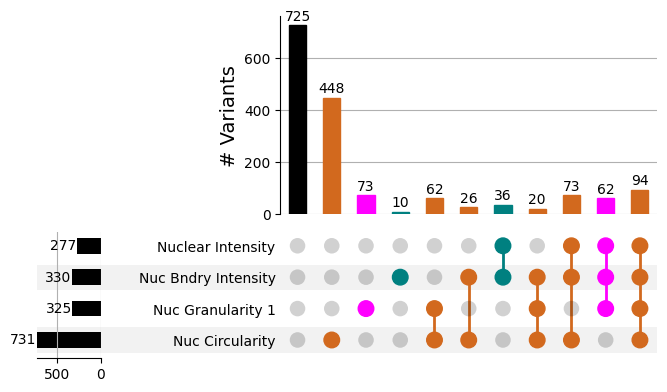

In [20]:
# Make a variant venn diagram 
syn_z_cutoff = 2.5
p_value_thresh_tot = 10**(-2)/(np.prod(df_KSpvalues_merged.shape))
landmark_features = \
    ['Mean_NucleiExpanded_Intensity_MeanIntensity_CH1',
     'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1',
     'Mean_NucleiExpanded_Granularity_1_CH1',
     'Mean_Nuclei_AreaShape_FormFactor'
    ]
feature_rename = \
    {
     'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1':'Nuclear Intensity',
     'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1':'Nuc Bndry Intensity',
     'Mean_NucleiExpanded_Granularity_1_CH1':'Nuc Granularity 1',
     'Mean_Nuclei_AreaShape_FormFactor': 'Nuc Circularity'
    }

# Get sets of significant variantsthat pass z-thresh and p-thresh
def find_significant_variants(df_z, df_p, features, p_thresh, z_thresh):
    # Because df_p is indexed by Variant, we can reindex or simply locate:
    # Make sure df_z rows align to df_p index
    df_p_filt = df_p.loc[df_z["Variant"]]
    
    sets_dict = {}
    for f in features:
        # Condition: p < p_thresh and EMD z > z_thresh
        pass_mask = (
            (df_p_filt[f].values <= p_thresh) &
            (df_z[f].values >= z_thresh)
        )
        # Collect the variants that pass
        passing_variants = df_p_filt[pass_mask].index
        sets_dict[f] = set(passing_variants)

    # get all missense set
    all_missense_set = set(df_z["Variant"])
    
    return sets_dict,all_missense_set

def sets_to_multiindex_series(all_variants, sets_dict, feature_ordering):
    """
    Convert a dictionary of sets {feature: set_of_variants} 
    plus a set of all variants into a multi-index Series for UpSetPlot.
    
    - all_variants: iterable of all Single Missense variants
    - sets_dict: {feature_name: set_of_variants_that_pass_that_feature}

    Returns:
    - A pd.Series with a multi-level boolean index (one level per feature),
      and values = count of how many variants fall into each True/False combination.
    """
    features = feature_ordering
    all_variants = sorted(all_variants)

    # 1) Build a boolean DataFrame
    df_bool = pd.DataFrame(False, index=all_variants, columns=features)
    for feat, varset in sets_dict.items():
        df_bool.loc[df_bool.index.intersection(varset), feat] = True

    # 2) Group by all columns to get counts of each combination
    #    This yields a multi-index (one level per column),
    #    with the aggregated values = how many rows (variants) in that combination.
    df_count = df_bool.groupby(features).size()

    return df_count

# set feature dataframes
df_z_toplot = \
    variant_EMD_merged[['Variant','Variant_Class'] + landmark_features]\
        .query('Variant_Class in ["Single Missense"]')\
        .query('Variant in @df_KSpvalues_merged.index')\
        .copy()
df_p_toplot = \
    df_KSpvalues_merged[landmark_features].copy()

# Rename columns
df_z_toplot.rename(columns=feature_rename, inplace=True)
df_p_toplot.rename(columns=feature_rename, inplace=True)

# Find significant variants
sig_sets,all_missense_set = \
    find_significant_variants(df_z_toplot, 
                              df_p_toplot, 
                              [feature_rename[f] for f in landmark_features], 
                              p_value_thresh_tot, 
                              syn_z_cutoff)

# Convert to Multi-Index set
df_count = sets_to_multiindex_series(all_missense_set, 
                                     sig_sets,
                                     feature_ordering=[feature_rename[f] for f in landmark_features])

# Pass that series to UpSet
pd.options.mode.copy_on_write = False # needed to fix upset plot, otherwise bug
upset_obj = UpSet(df_count,
                  sort_by='degree',
                  sort_categories_by='-input',
                  show_counts=True,
                  min_subset_size=10
                 )
upset_obj.style_subsets(
    present=['Nuclear Intensity'], 
    facecolor="teal"
)
upset_obj.style_subsets(
    present=['Nuc Bndry Intensity'], 
    facecolor="teal"
)
upset_obj.style_subsets(
    present=['Nuc Granularity 1'], 
    facecolor="fuchsia"
)
upset_obj.style_subsets(
    present=['Nuc Circularity'], 
    facecolor="chocolate"
)
upset_obj.plot()
pd.options.mode.copy_on_write = True

plt.ylabel('# Variants', fontsize=14)
plt.savefig('./consensus_plots/LMNAT3.upsetplot.landmarkfeatures.EMD.012625.pdf')
plt.show()
